<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo on simulation data

## Load packages

In [ ]:
!pip install KDEpy velocyto dynamo-release scvelo

In [3]:
!git clone https://github.com/meichenfang/Poisson-regression.git

Cloning into 'Poisson-regression'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 161 (delta 38), reused 39 (delta 12), pack-reused 87
Receiving objects: 100% (161/161), 164.80 MiB | 20.13 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Checking out files: 100% (24/24), done.


In [21]:
%cd Poisson-regression/functions
from EM_functions_single import *
from EM_functions import *
from MC_functions import *
from plot_functions import *
%cd ../../

/content/Poisson-regression/functions
/content


In [1]:
%cd functions
from EM_functions_single import *
from EM_functions import *
from MC_functions import *
from plot_functions import *
%cd ../

/home/mffang/workspace/Trajectory/Poisson-regression/functions
/home/mffang/workspace/Trajectory/Poisson-regression


In [2]:
import anndata as ad
import velocyto as vcy
import scvelo as scv
import dynamo as dyn

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


## Generate data

In [3]:
#%% generate data
np.random.seed(2022)
n = 2000
p = 20
tau=(0,1)
K=len(tau)-1
t=np.linspace(0, 1, n)

theta=np.ones((p,K+4))*5
loga_max=4
logb_max=2

for j in range(K+2):
    theta[:,j]=np.exp(np.random.uniform(0,loga_max,size=p))-1

theta[:,-1]=5*(np.exp(np.random.uniform(-logb_max,logb_max,size=p)))
theta[:,-3]=theta[:,-4]*theta[:,-2]/theta[:,-1]
gamma = theta[:,-1]/5

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

theta_true = theta.copy()
adata=ad.AnnData(np.sum(X,axis=-1))
adata.layers["spliced"] = X[:,:,1]
adata.layers["unspliced"] = X[:,:,0]
adata.layers["ambiguous"]=np.zeros_like(X[:,:,0])
adata.obs["time"]=t
adata.var["true_gamma"]=gamma
adata.write_loom("data/simulation_20.loom")

In [3]:
#%% generate data
np.random.seed(2022)
n = 2000
p = 1000
tau=(0,1)
K=len(tau)-1
t=np.linspace(0, 1, n)

theta=np.ones((p,K+4))*5
loga_max=4
logb_max=2

for j in range(K+2):
    theta[:,j]=np.exp(np.random.uniform(0,loga_max,size=p))-1

theta[:,-1]=5*(np.exp(np.random.uniform(-logb_max,logb_max,size=p)))
theta[:,-3]=theta[:,-4]*theta[:,-2]/theta[:,-1]
gamma = theta[:,-1]/5

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

theta_true = theta.copy()
adata=ad.AnnData(np.sum(X,axis=-1))
adata.layers["spliced"] = X[:,:,1]
adata.layers["unspliced"] = X[:,:,0]
adata.layers["ambiguous"]=np.zeros_like(X[:,:,0])
adata.obs["time"]=t
adata.var["true_gamma"]=gamma
adata.write_loom("data/simulation_1000.loom")

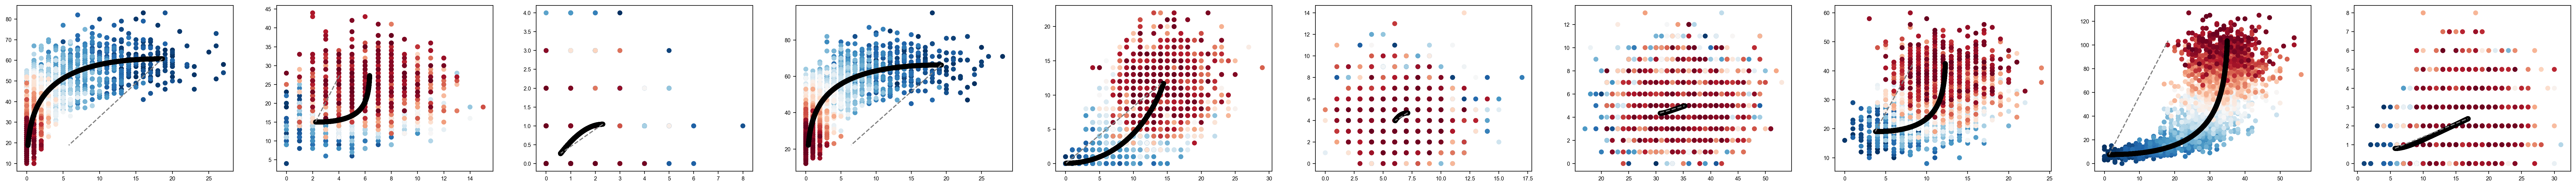

In [4]:
fig, ax = plt.subplots(1,10,figsize=(6*10,4))
for i in range(10):
    ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c=t);
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='black');

In [6]:
traj=Trajectory(topo=np.array([[0,],]),tau=(0,1))
Q, elbos = traj.fit_(X,100,n_init=3,parallel=True,n_threads=2)

trial 0


  0%|          | 0/10 [01:14<?, ?it/s]


KeyboardInterrupt: 

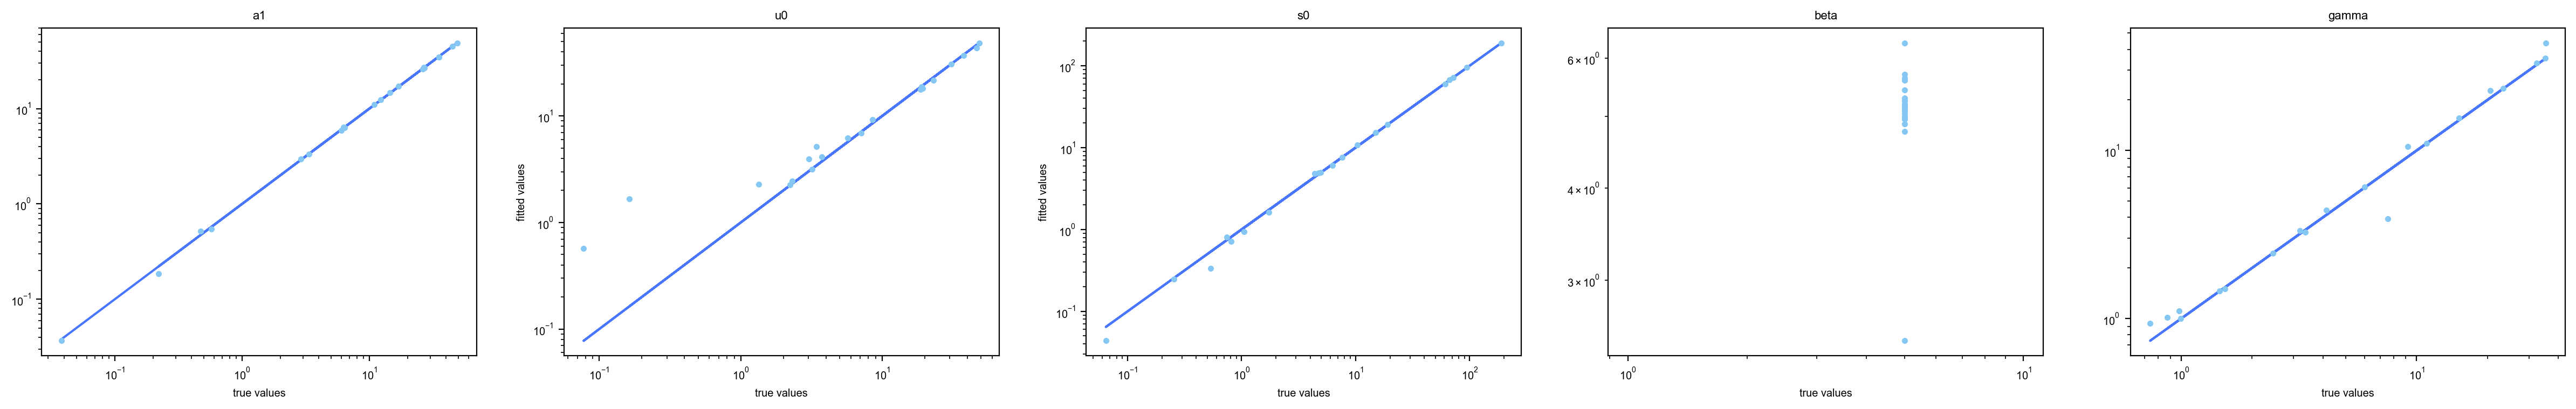

In [11]:
plot_theta(theta_true,traj.theta)

In [12]:
Q, elbo = traj.update_weight(X)

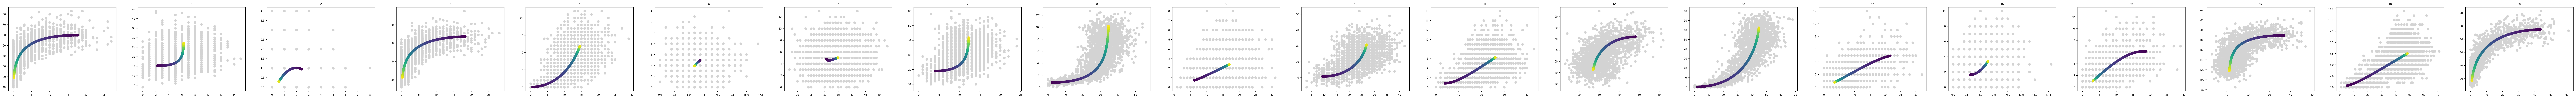

In [13]:
topo=np.array([[0,],])
tau=(0,1)
plot_phase(X,traj.theta,Q,topo,tau)

## velocyto

In [14]:
def run_velocyto(loomfile,quiver_scale="auto"):
    vlm = vcy.VelocytoLoom(loomfile)
    vlm.normalize()
    vlm.perform_PCA()
    vlm.knn_imputation()
    vlm.fit_gammas()
    vlm.normalize(which="imputed", size=False, log=True)
    vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")
    vlm.predict_U()
    vlm.calculate_velocity()
    vlm.calculate_shift(assumption="constant_velocity")
    vlm.extrapolate_cell_at_t(delta_t=1.)
    vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="sqrt")
    vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)
    vlm.calculate_grid_arrows(smooth=0.5, steps=(25, 25))
    fig = plt.figure(figsize=(12,4))
    fig.add_subplot(121)
    vlm.colorandum = t
    vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},quiver_scale=quiver_scale)
    fig.add_subplot(122)
    plt.plot(vlm.ra["true_gamma"],vlm.gammas,'.');
    plt.plot(vlm.ra["true_gamma"],vlm.ra["true_gamma"],'r-');

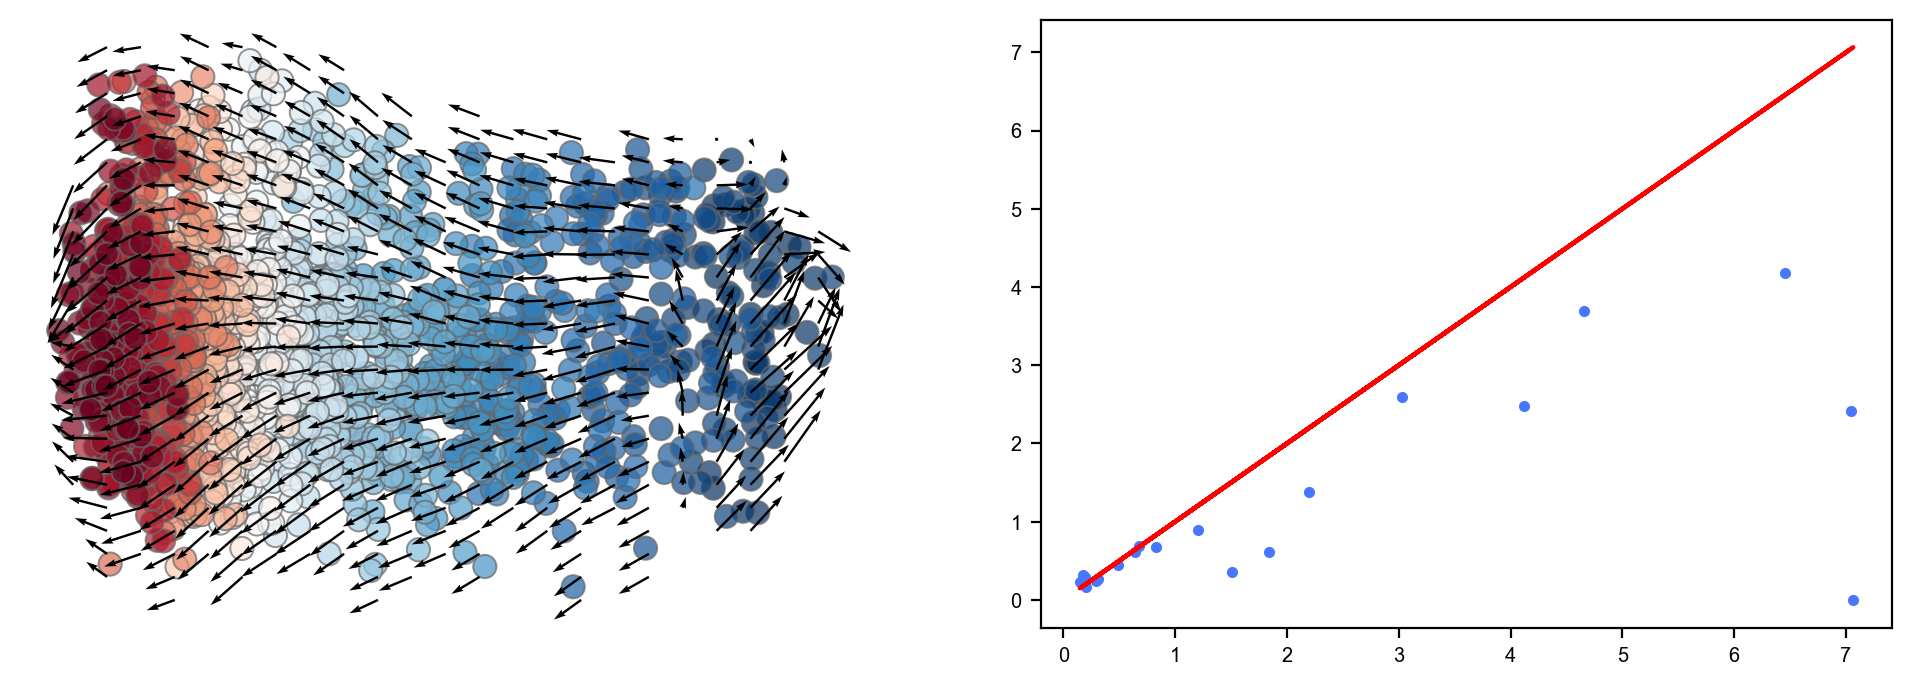

In [15]:
run_velocyto("data/simulation_20.loom", quiver_scale=0.1)

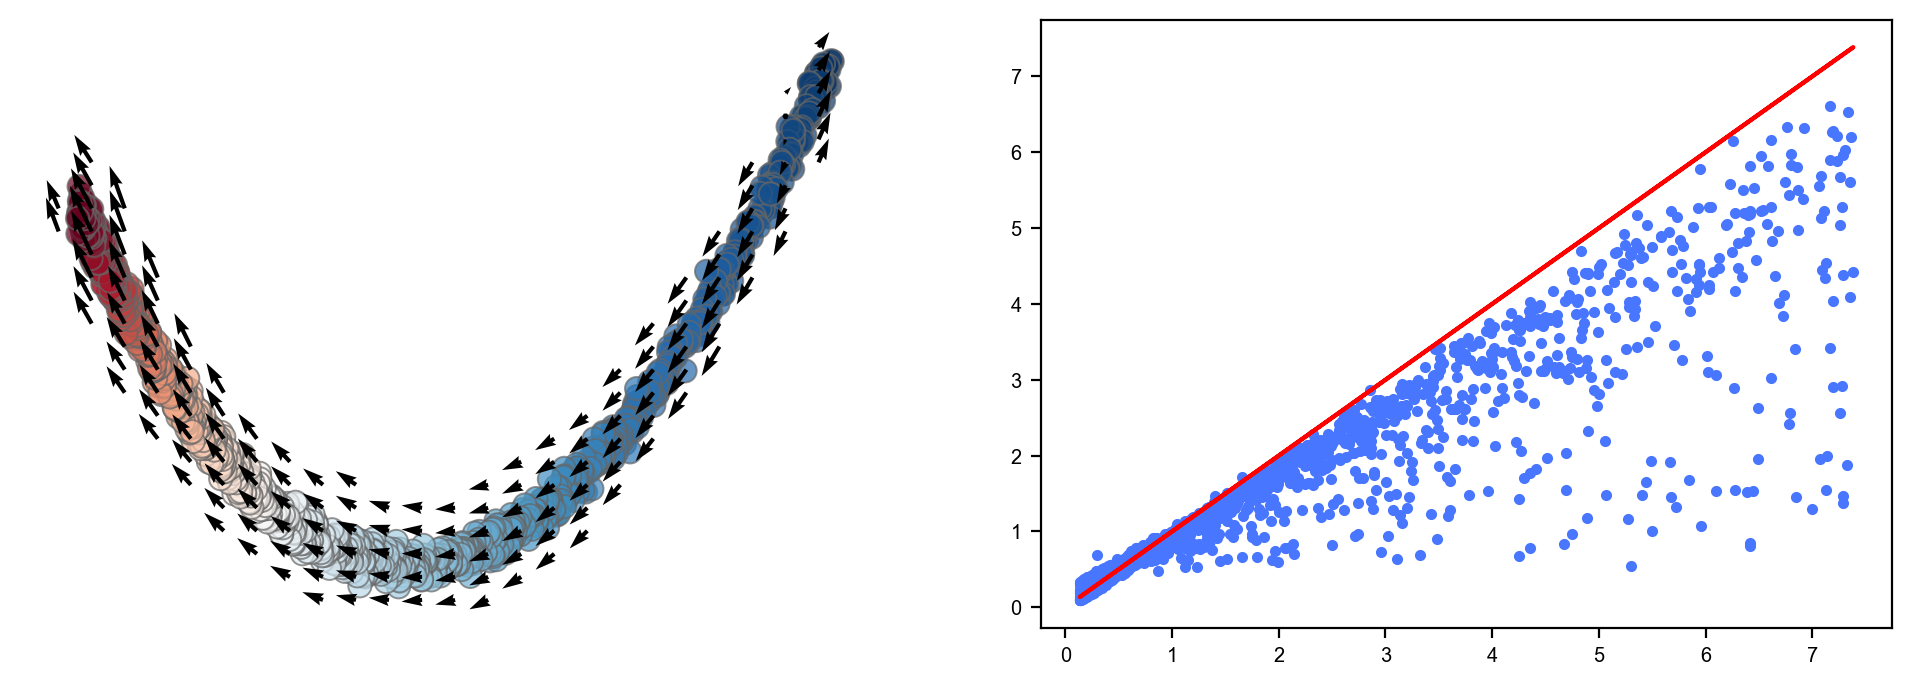

In [17]:
run_velocyto("data/simulation_2000.loom")

## scvelo

In [18]:
def run_scvelo(loomfile,dynamical=False):
    adata = scv.read_loom(loomfile)
    scv.pp.filter_and_normalize(adata, min_shared_counts=0, n_top_genes=2000)
    scv.pp.moments(adata)
    if dynamical:
        scv.tl.recover_dynamics(adata,n_jobs=2)
        scv.tl.velocity(adata, mode='dynamical')
    else:
        scv.tl.velocity(adata)

    scv.tl.velocity_graph(adata,basis='pca')
    scv.pl.velocity_embedding_stream(adata, color=t,basis='pca')

    idx = adata.var['velocity_genes']
    true_gamma = adata.var['true_gamma']
    gammas = adata.var['velocity_gamma']
    plt.plot(true_gamma[idx],gammas[idx],'.');
    plt.plot(true_gamma[idx],true_gamma[idx],'r-');
    return adata
  

In [19]:
run_scvelo("data/simulation_20.loom",dynamical=False)

Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 1/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


KeyError: 'X_pca'

In [ ]:
run_scvelo("data/simulation_20.loom",dynamical=True)

Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 1/8 cores)
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


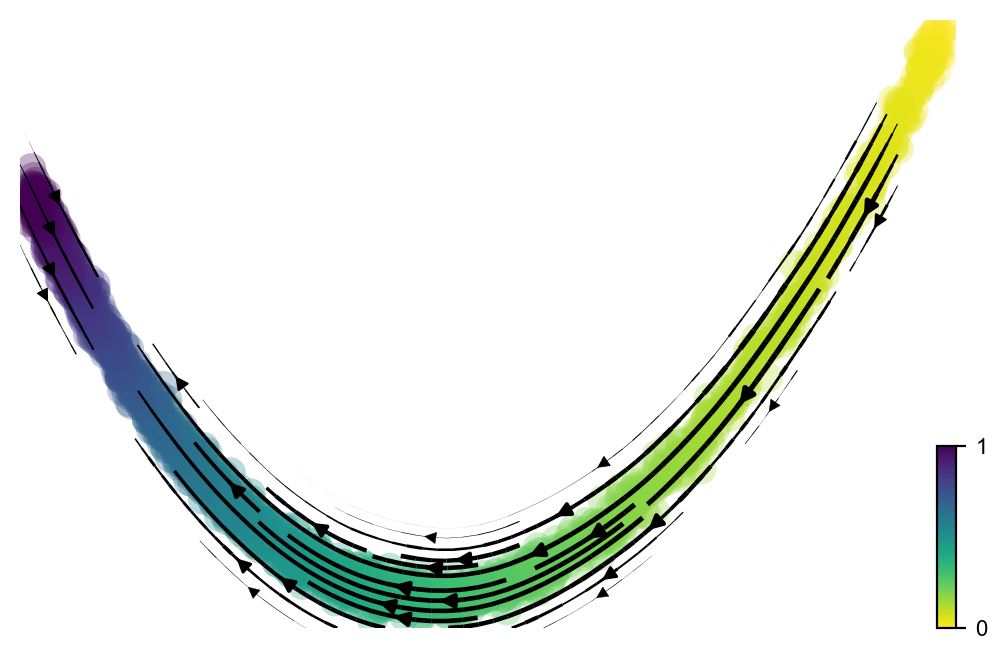

AnnData object with n_obs × n_vars = 2000 × 2000
    obs: 'time', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'true_gamma', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'velocity_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

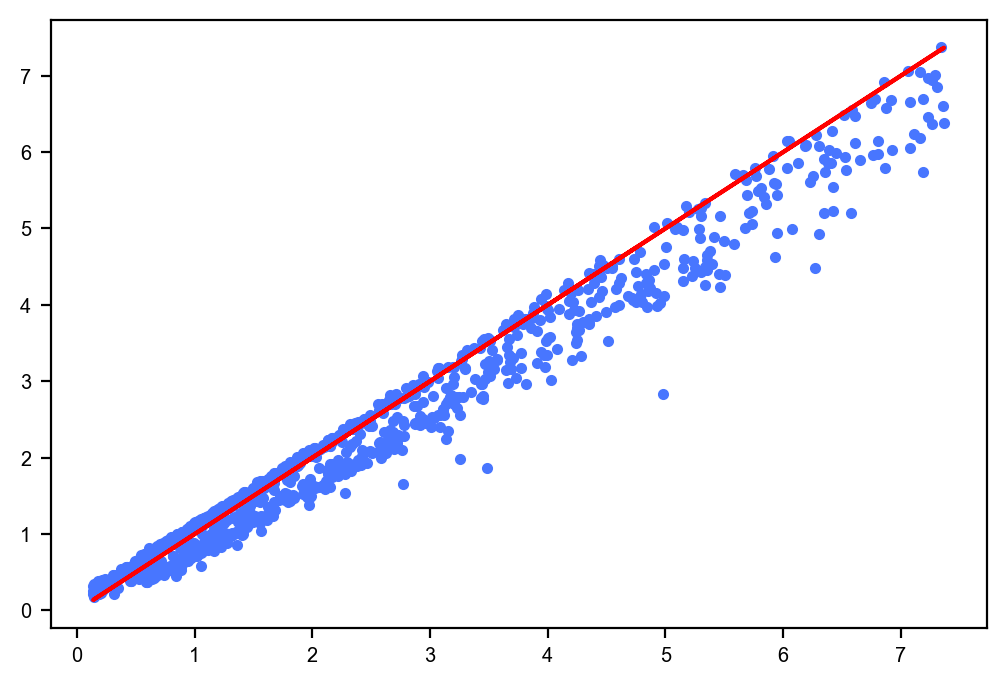

In [20]:
run_scvelo("data/simulation_2000.loom",dynamical=False)

In [22]:
run_scvelo("data/simulation_2000.loom",dynamical=True)

Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 2/8 cores)


KeyboardInterrupt: 

## dynamo

In [ ]:
def run_dynamo(loomfile,basis='pca'):
    adata = dyn.read_loom(loomfile)
    dyn.pp.recipe_monocle(adata)
    dyn.tl.dynamics(adata)
    dyn.tl.reduceDimension(adata, basis=basis, enforce=True)
    dyn.tl.cell_velocities(adata, basis=basis)
    dyn.pl.streamline_plot(adata, color=["time"], basis=basis)
    dyn.vf.VectorField(adata, basis=basis)
    dyn.pl.topography(adata, basis=basis,fps_basis=basis)
    true_gamma = adata.var['true_gamma']
    gammas = adata.var['gamma']
    plt.plot(true_gamma,gammas,'.');
    plt.plot(true_gamma,true_gamma,'r-');

### pca

In [ ]:
run_dynamo("simulation_15.loom",basis='pca')

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['

estimating gamma: 100%|██████████| 2000/2000 [01:24<00:00, 23.74it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [20.0492s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

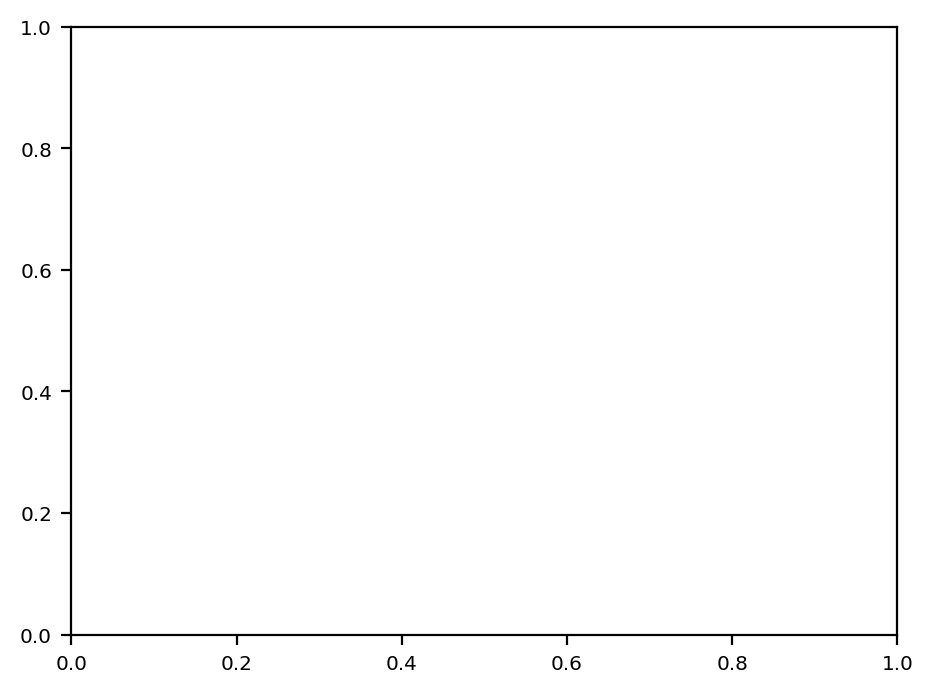

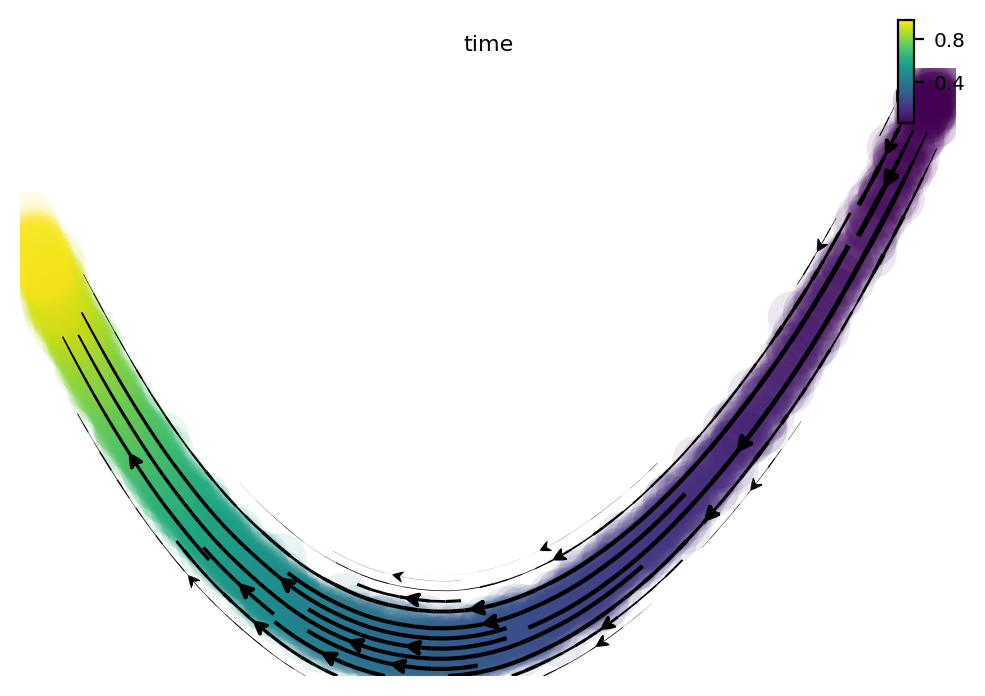

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.1857s]
|-----> <insert> velocity_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_pca to uns in AnnData Object.
|-----> <insert> control_point_pca to obs in AnnData Object.
|-----> <insert> inlier_prob_pca to obs in AnnData Object.
|-----> <insert> obs_vf_angle_pca to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [0.3955s]
|-----> Vector field for pca is but its topography is not mapped. Mapping topography now ...
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on 

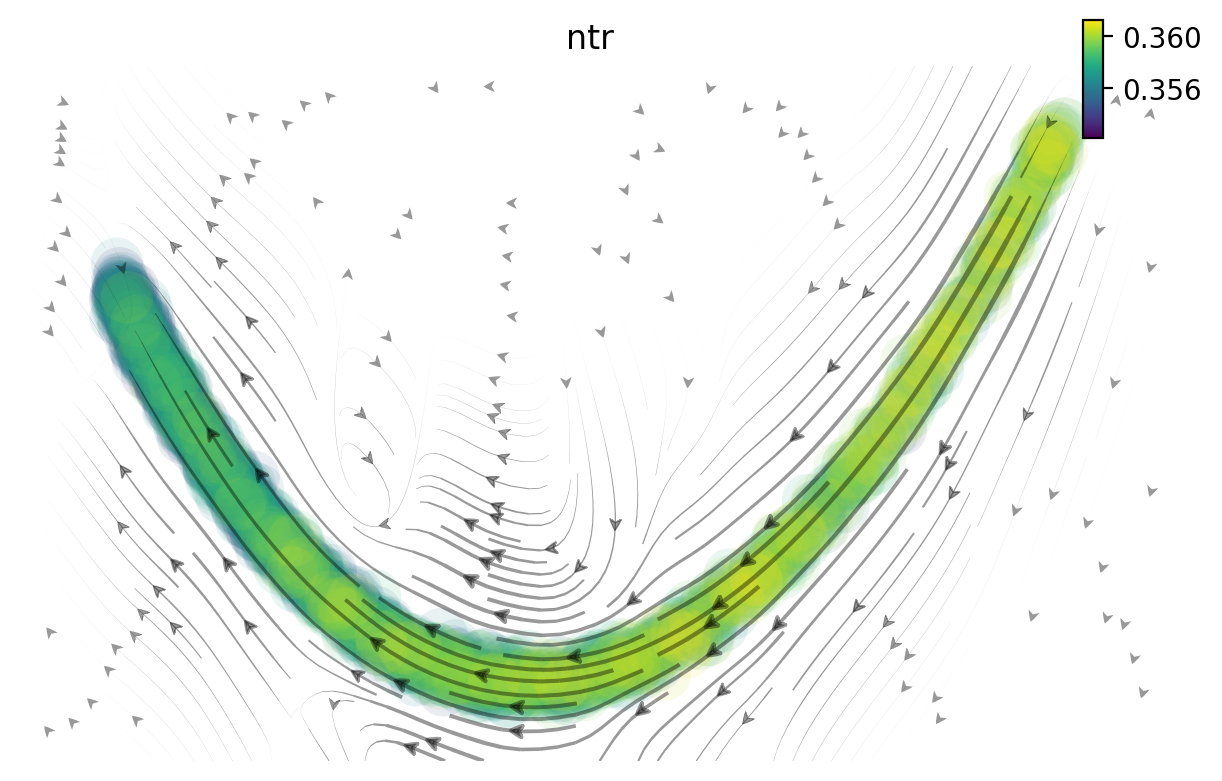

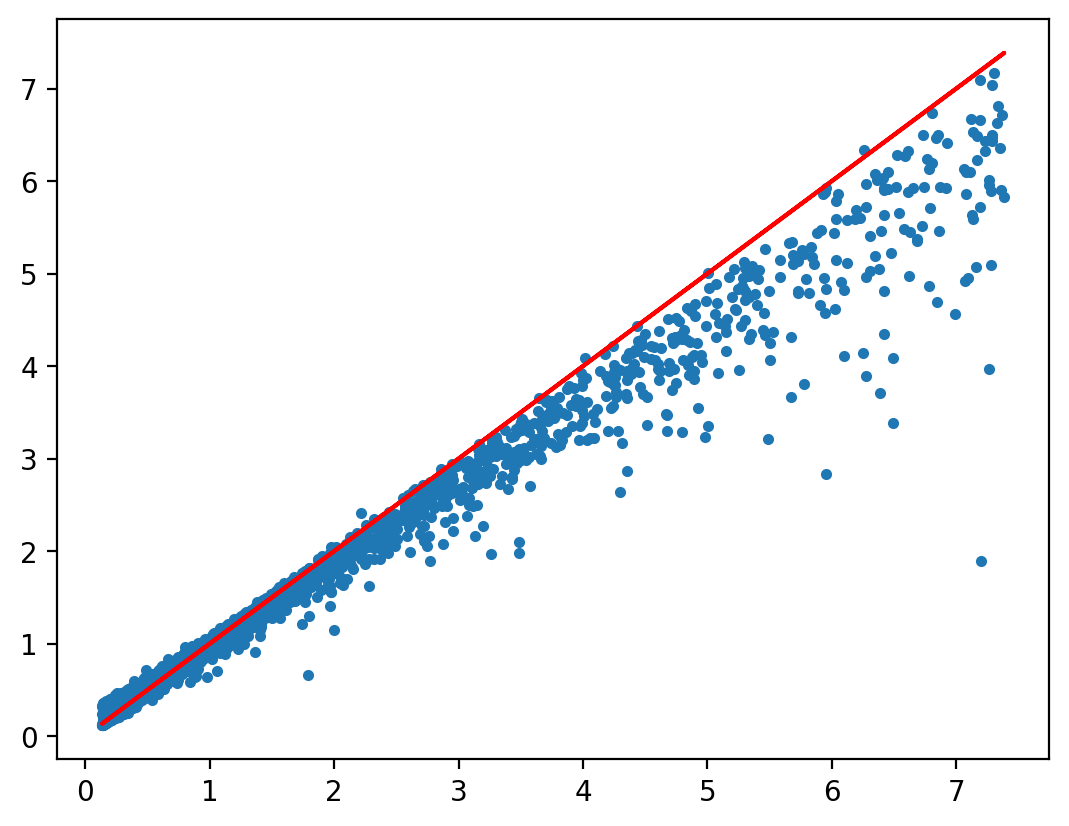

In [ ]:
run_dynamo("simulation_2000.loom",basis='pca')

### umap

In [ ]:
run_dynamo("simulation_15.loom",basis='umap')

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['

estimating gamma: 100%|██████████| 15/15 [00:00<00:00, 283.38it/s]

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...


|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [20.5576s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----? Only less than 5 genes satisfies transition gene selection criteria, which may be resulted from: 
  1. Very low intron/new RNA ratio, tr

ValueError: ignored

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['

estimating gamma: 100%|██████████| 2000/2000 [01:32<00:00, 21.54it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [20.6689s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

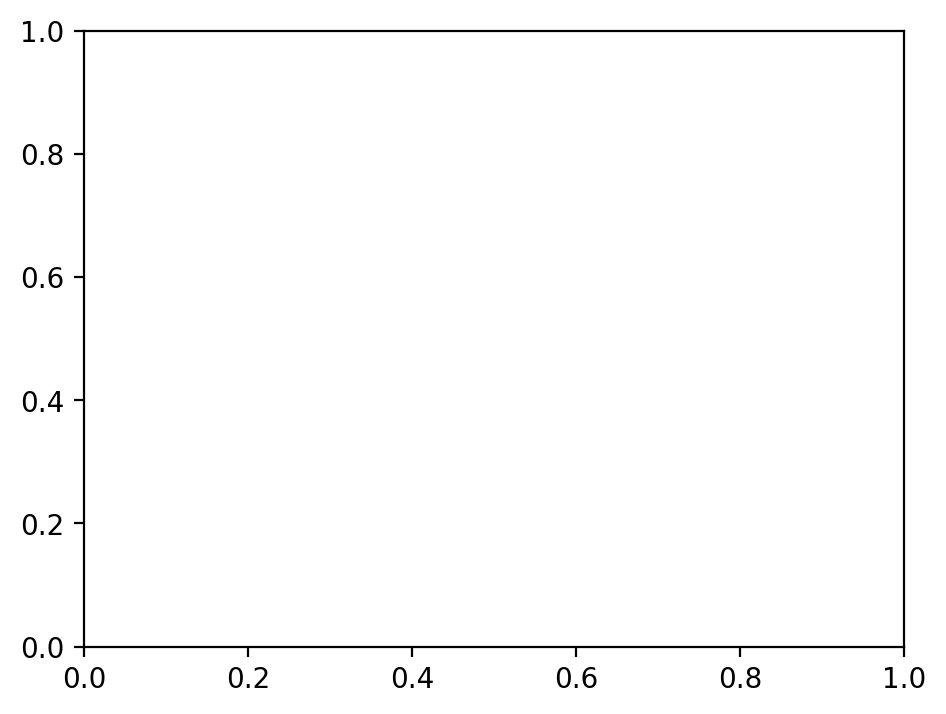

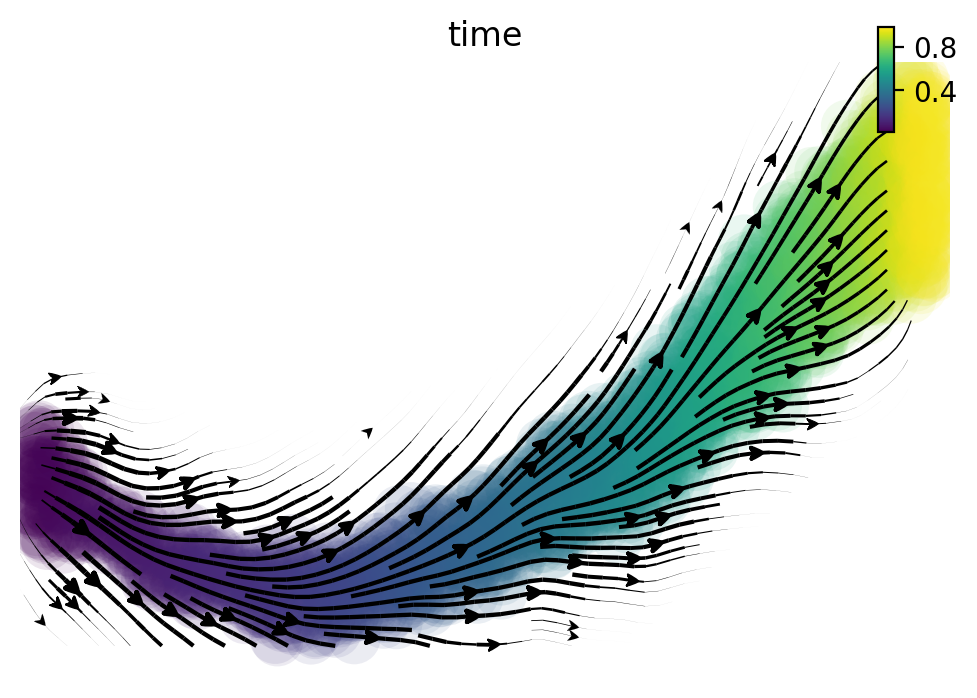

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.3623s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.
|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [0.5958s]
|-----> Vector field for umap is but its topography is not mapped. Mapping topography now .

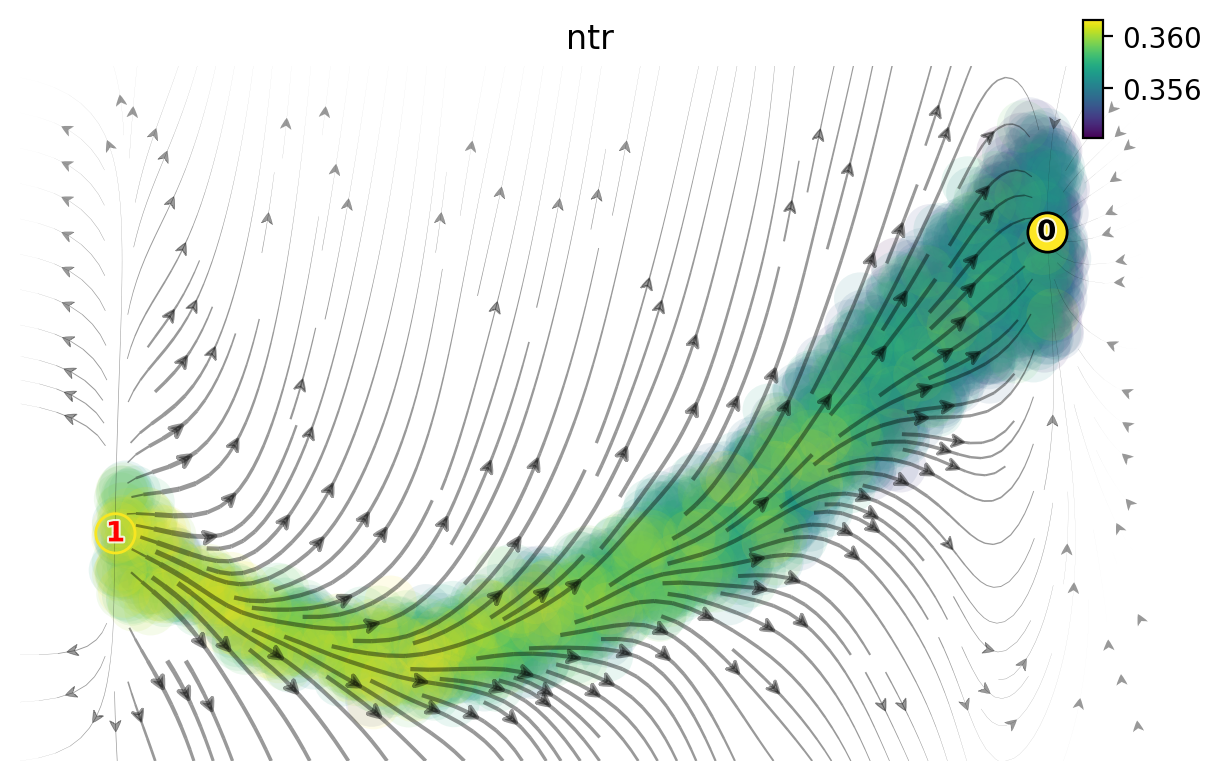

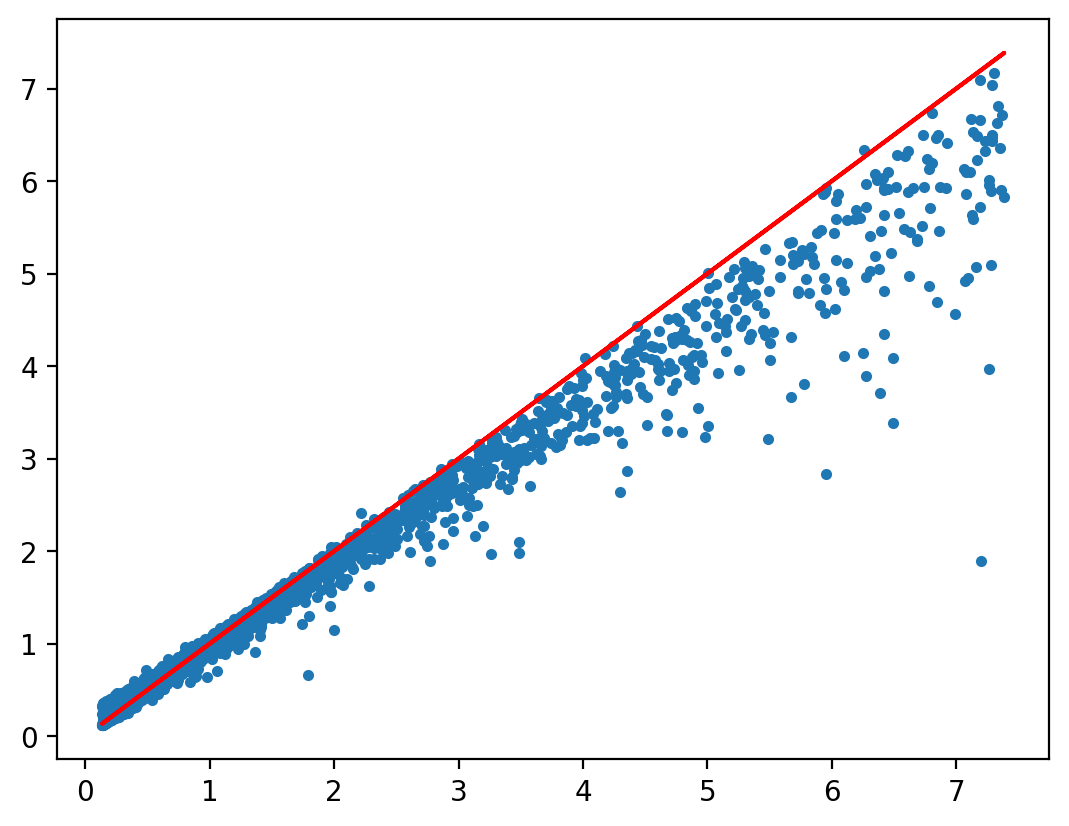

In [ ]:
run_dynamo("simulation_2000.loom",basis='umap')

# CEM vs EM

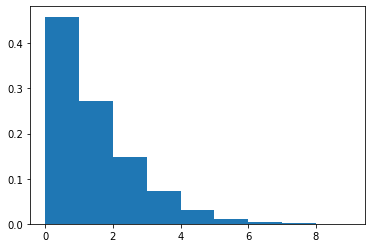

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N=100000
c=0.2
z=np.random.uniform(0,10,size=N)
y=np.random.poisson(z)
x=np.random.poisson(c*y)
plt.hist(x,bins=np.arange(0,10),density=True);

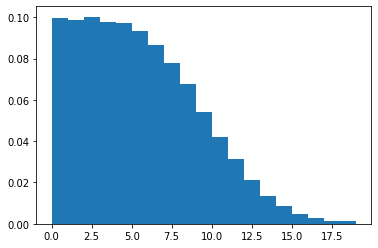

In [ ]:
plt.hist(y,bins=np.arange(0,20),density=True);

In [ ]:
def CEM_Q(theta,x):
    eps=1e-100
    h=np.linspace(0,theta,100)[None,:]
    ll=x[:,None]*np.log(h+eps)-h
    Q = np.mean(np.amax(ll,axis=1))
    return Q

In [ ]:
n=51
thetas = np.linspace(1,5,n)
Qs = np.zeros(n)
for i in range(n):
    Qs[i]=CEM_Q(thetas[i],x)

5.0


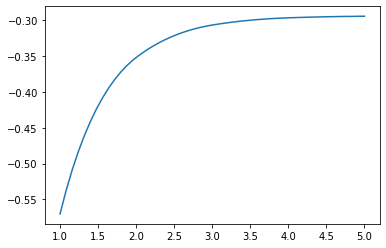

In [ ]:
plt.plot(thetas,Qs)
idx = np.argmax(Qs)
print(thetas[idx])

In [ ]:
from scipy.special import softmax

def EM_Q(theta,x):
    eps=1e-100
    h=np.linspace(0,theta,100)
    h=h[None,:]
    ll=x[:,None]*np.log(h+eps)-h
    q=softmax(ll,axis=1)
    Q=np.mean(np.sum(q*ll-q*np.log(q+eps),axis=1))
    return Q

In [ ]:
n=21
thetas = np.linspace(1.9,2.1,n)
Qs = np.zeros(n)
for i in range(n):
    Qs[i]=EM_Q(thetas[i],x)

2.0300000000000002


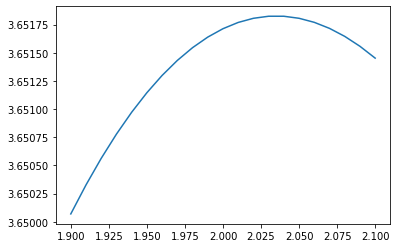

In [ ]:
plt.plot(thetas,Qs)
idx = np.argmax(Qs)
print(thetas[idx])

In [ ]:
n=21
thetas = np.linspace(9.9,10.1,n)
Qs = np.zeros(n)
for i in range(n):
    Qs[i]=EM_Q(thetas[i],y)

10.02


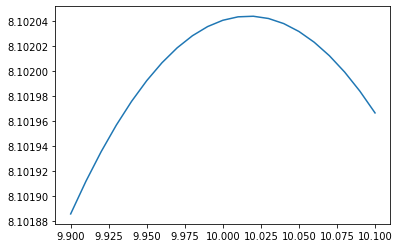

In [ ]:
plt.plot(thetas,Qs)
idx = np.argmax(Qs)
print(thetas[idx])

# Toggle switch

\begin{align}
&\frac{du_1}{dt} = \frac{\alpha_1}{1 + (s_2/k_1)^n} - \beta_1 u_1,\\[1em]
&\frac{ds_1}{dt} = \beta_1 u_1 - \gamma_1 s_1,\\[1em]
&\frac{du_2}{dt} = \frac{\alpha_2}{1 + (s_1/k_2)^n} - \beta_2 u_2,\\[1em]
&\frac{ds_2}{dt} = \beta_2 u_2 - \gamma_2 s_2.
\end{align}

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt


In [ ]:
# Parameters
alpha_1 = 100
alpha_2 = 50
beta_1 = 6
beta_2 = 4
gamma_1 = 1
gamma_2 = 18
k_1 = 4
k_2 = 4
n = 4

func_args = (alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k_1, k_2, n)

In [ ]:
def toggle_switch(t, y, alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k_1, k_2, n): 
  u_1, s_1, u_2, s_2 = y
  du_1_dt = alpha_1/(1 + (s_2/k_1)**n) - beta_1 * u_1
  ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
  du_2_dt = alpha_2/(1 + (s_1/k_2)**n) - beta_2 * u_2
  ds_2_dt = beta_2 * u_2 - gamma_2 * s_2

  return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt]

In [ ]:
def piecewise(t, y, alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k_1, k_2, n): 
  u_1, s_1, u_2, s_2 = y
  if t>0.03:
    alpha_1 = 0.032
  """ 
  if (s_2/k_1)**n > 1:
    alpha_1 = 0
  if (s_1/k_2)**n > 1:
    alpha_2 = 0
  """
  du_1_dt = alpha_1 - beta_1 * u_1
  ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
  du_2_dt = alpha_2 - beta_2 * u_2
  ds_2_dt = beta_2 * u_2 - gamma_2 * s_2

  return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt]

In [ ]:
T=1
n=1000

sol_toggle_switch = solve_ivp(toggle_switch, [0, T], [0, 0, 3, 3], args=func_args, t_eval = np.linspace(0,T,n))
sol_piecewise = solve_ivp(piecewise, [0, T], [0, 0, 3, 3], args=func_args, t_eval = np.linspace(0,T,n))

"\nax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');\nax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');\nax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');\n"

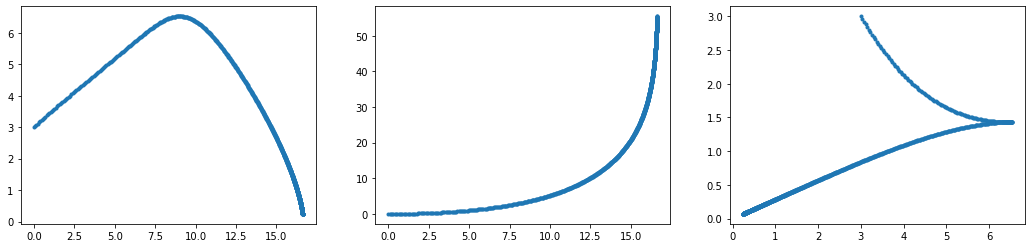

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[2],'.');
ax[1].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[1],'.');
ax[2].plot(sol_toggle_switch.y[2],sol_toggle_switch.y[3],'.');
"""
ax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');
ax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');
ax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');
"""

In [ ]:
X=np.zeros((n,2,2))
X[:,0,:] = np.random.poisson(sol_toggle_switch.y[0:2,:].T)
X[:,1,:] = np.random.poisson(sol_toggle_switch.y[2:,:].T)

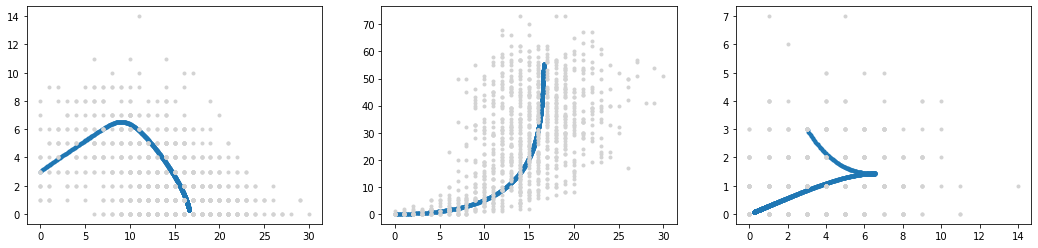

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[2],'.');
ax[1].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[1],'.');
ax[2].plot(sol_toggle_switch.y[2],sol_toggle_switch.y[3],'.');

ax[0].plot(X[:,0,0],X[:,1,0],'.',color='lightgray');
ax[1].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[2].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');

In [ ]:
Y=np.zeros((n,2,2))
Y_=np.zeros((n,2,2))
Y[:,0,:] = sol_toggle_switch.y[0:2,:].T
Y[:,1,:] = sol_toggle_switch.y[2:,:].T
Y_[:,0,:] = sol_piecewise.y[0:2,:].T
Y_[:,1,:] = sol_piecewise.y[2:,:].T

In [ ]:
logL = np.sum(X*np.log(Y+1e-6)-Y)

In [ ]:
logL_ = np.sum(X*np.log(Y_+1e-6)-Y_)

In [ ]:
logL, logL_

(19345.1814616582, 13911.119512963363)

In [ ]:
for seed in range(10):
  np.random.seed(seed)
  X=np.zeros((n,2,2))
  X[:,0,:] = np.random.poisson(sol_toggle_switch.y[0:2,:].T)
  X[:,1,:] = np.random.poisson(sol_toggle_switch.y[2:,:].T)
  logL = np.sum(X*np.log(Y+1e-6)-Y)
  logL_ = np.sum(X*np.log(Y_+1e-6)-Y_)
  print(logL, logL-logL_)


18880.03571626807 5324.7042063090485
19724.00254796687 5387.765836425984
19336.116476591138 5456.129096193097
19305.694539013144 5396.7025164842125
19103.44532761584 5333.563512339071
20141.930441571225 5433.368832422024
19846.408754534918 5228.998521898915
19225.844159742093 5459.7499646718425
19235.319949735633 5410.745083105829
19578.211082575617 5464.637577697415


## Fit toggle switch with piecewise

In [ ]:
weight=np.diag(v=[1]*n)
tau = (0,0.5,1)
penalty=0
theta_hat = update_theta(X,weight,tau,penalty,alternative=False,parallel=True,n_threads=2,theta0=None, bnd=1000)

In [ ]:
t=np.linspace(0,1,n)
Y_fit = get_Y(theta_hat,t,tau)

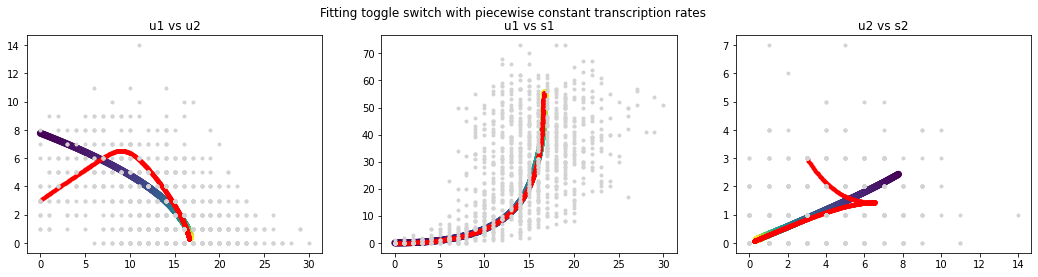

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("Fitting toggle switch with piecewise constant transcription rates")

ax[0].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[2],'r.');
ax[0].set_title("u1 vs u2")
ax[1].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[1],'r.');
ax[1].set_title("u1 vs s1")
ax[2].plot(sol_toggle_switch.y[2],sol_toggle_switch.y[3],'r.');
ax[2].set_title("u2 vs s2")

ax[0].plot(X[:,0,0],X[:,1,0],'.',color='lightgray');
ax[1].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[2].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');

ax[0].scatter(Y_fit[:,0,0],Y_fit[:,1,0],c=t);
ax[1].scatter(Y_fit[:,0,0],Y_fit[:,0,1],c=t);
ax[2].scatter(Y_fit[:,1,0],Y_fit[:,1,1],c=t);

In [ ]:
theta_hat

array([[16.52106173, 16.83319367,  0.        ,  0.        ,  5.82877743,
         0.93046774],
       [ 0.18237896,  0.        ,  7.77194007,  2.43075787,  3.11594158,
        13.72520698]])

# Nothing out of nothing

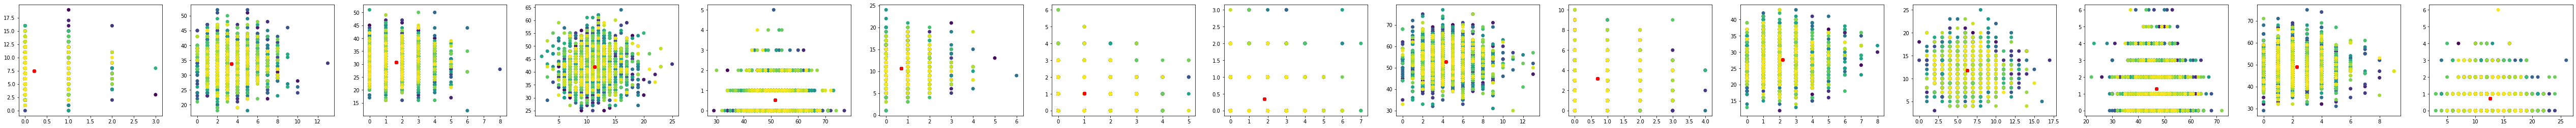

In [ ]:
#%% generate data
np.random.seed(84)
n = 1500
p = 15
Tau=[0,0.5]
tau=(0,0.5,1)
K=len(tau)-1
t=np.linspace(0, 1, n)

theta=np.zeros((p,K+4))
loga_max=4
logb_max=2
theta[:,0]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,1]=theta[:,0]
theta[:,-4]=theta[:,0]
theta[:,-3]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-2]=1
theta[:,-1]=theta[:,-4]/theta[:,-3]

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c=t);
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='r');

In [ ]:
weight=np.diag(v=[1]*n)
tau = (0,0.5,1)
penalty=0
theta_hat = update_theta(X,weight,tau,penalty,alternative=False,parallel=True,n_threads=2,theta0=None, bnd=1000)

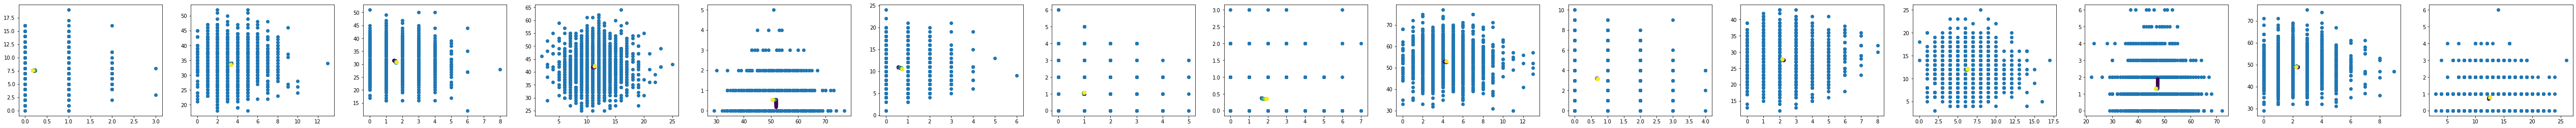

In [ ]:
t=np.linspace(0,1,n)
Y_fit = get_Y(theta_hat,t,tau)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1]);
    ax[i].scatter(Y_fit[:,i,0],Y_fit[:,i,1],c=t);

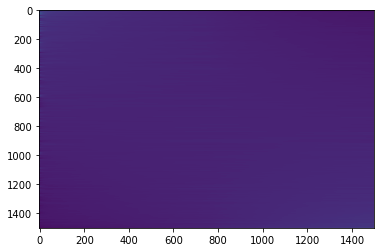

In [ ]:
new_weight = update_weight(X,theta_hat,tau,n)
plot_t(new_weight)

In [ ]:
weight=np.diag(v=[1]*n)
tau = (0,0.5,1)
penalty=n*0.001
theta_hat = update_theta(X,weight,tau,penalty,alternative=False,parallel=True,n_threads=2,theta0=None, bnd=1000)

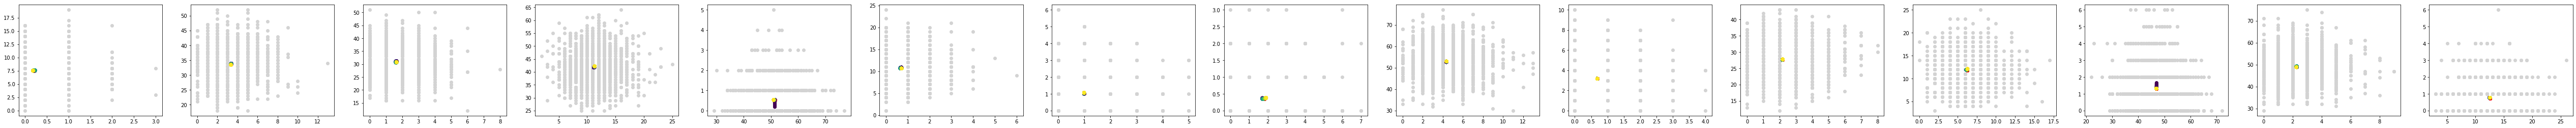

In [ ]:
t=np.linspace(0,1,n)
Y_fit = get_Y(theta_hat,t,tau)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c='lightgray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='r');
    ax[i].scatter(Y_fit[:,i,0],Y_fit[:,i,1],c=t);

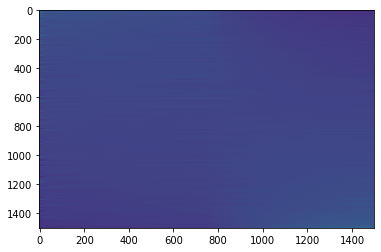

In [ ]:
new_weight = update_weight(X,theta_hat,tau,n)
plot_t(new_weight)